To note:

- No idea what b is 
- Below is a couple of definitions from the GitHub page which might come in handy

Link travel time = free flow time * ( 1 + B * (flow/capacity)^Power ).
Link generalized cost = Link travel time + toll_factor * toll + distance_factor * distance

# Setup: import packages

In [131]:
#install packages if required
#%pip install networkx

In [132]:
#import packages 
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphviz
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
from scipy.misc import derivative
import os
from random import *

In [133]:
network_analysis_path_ben = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/pytrans_UrbanNetworkAnalysis/pytrans/UrbanNetworkAnalysis/Originals_edited'
#network_analysis_path_niamh = r'C:\Users\35387\OneDrive\Documents\Networks\New folder\Networks_Term_Paper\pytrans_UrbanNetworkAnalysis\pytrans\UrbanNetworkAnalysis\original_edited'
os.chdir(network_analysis_path_ben)
import Frank_Wolfe
import TransportationNetworks as tn
import visualize_graph

# Read in data

data_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/'
city = 'Birmingham'
data_path = data_path + city + '/'
os.chdir(data_path)
link_file_path = data_path + city + '_net.tntp'
node_file_path = data_path + city +'_nodes.tntp'
trip_file_path = data_path+ city + '_trips.tntp'

# Load Data

In [134]:
data_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/'
cities = ['SiouxFalls']
data_path = data_path 
os.chdir(data_path)

In [135]:
#create dictionary with cities and three files: links, nodes and trips
#i apologise, the paths are horrible, you might need to fix but it's worth it in the long u
def make_dict(cities):
    cities_dict = {}
    for city in cities:
        link_file_path = data_path + city + '/' + city + '_net.tntp'
        node_file_path = data_path + city + '/' + city +'_nodes.tntp'
        trip_file_path = data_path + city + '/' + city + '_trips.tntp'
        cities_dict[city] = {}
        to_add = {'link_file_path': link_file_path, 'node_file_path': node_file_path, 'trip_file_path': trip_file_path}
        cities_dict[city]['file_paths'] = to_add 
    return cities_dict

In [137]:
cities_dict = make_dict(cities)
cities_dict

{'SiouxFalls': {'file_paths': {'link_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/SiouxFalls/SiouxFalls_net.tntp',
   'node_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/SiouxFalls/SiouxFalls_nodes.tntp',
   'trip_file_path': '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/SiouxFalls/SiouxFalls_trips.tntp'}}}

In [139]:
class fw_custom_algorithm():
    
    def __init__(self, cities_dict):
        self.cities_dict = cities_dict
        self.link_fields = {"from": 1, "to": 2, "capacity": 3, "length": 4, "t0": 5, "B": 6, "beta": 7, "V": 8}
    #create a csv for each city and corresponding file for investigation
    def create_csvs(self):
        for city in self.cities_dict.keys():
            path_list = list(self.cities_dict[city]['file_paths'].keys())
            for paths in path_list:
                #load network file
                link_file = path_list[0]
                csv = pd.read_csv(self.cities_dict[city]['file_paths'][link_file], skiprows=8, sep='\t') #gets link file path
                trimmed= [s.strip().lower() for s in csv.columns]
                csv.columns = trimmed
                # And drop the silly first andlast columns
                csv.drop(['~', ';'], axis=1, inplace=True)
                cities_dict[city]['csv'] = csv
        self.cities_dict = cities_dict
    
    def plot(self, city):
        csv = self.cities_dict[city]['csv']
        network = nx.from_pandas_edgelist(csv, source = 'init_node',target='term_node', edge_attr = True)
        graph = nx.complete_graph(network)
        nx.draw(graph)
        
    def summary_stats_all(self):
        for city in self.cities_dict.keys():
            print('Total number of nodes in', city+':', len(self.cities_dict[city]['csv']['init_node'].unique()))
            print('Total number of edges in', city+':', self.cities_dict[city]['csv'].shape[0])
            
    def network(self, city):
        #instatiate class using required files 
        link_file = self.cities_dict[city]['file_paths']['link_file_path']
        trip_file = self.cities_dict[city]['file_paths']['trip_file_path']
        node_file = self.cities_dict[city]['file_paths']['node_file_path']
        Network = tn.Network(link_file, trip_file, node_file)
        ##Network has three attributes
        #1) graph object
        graph = Network.graph
        #2) origin nodes
        origin_nodes = Network.origins
        #3)dict: keys= origin_node, destination_node, value = traffic flow
        flows = Network.od_vols
        print(Network)
        print(city, 'graph is:', graph)
        print(city, 'origin nodes are:', origin_nodes)
        print(city, 'flows are:', flows)
        
    #define a function for finding the equilibrim flow using the Frank-Wolfe algorithm from PyTrans
    def compute_all_link_flow(self, city):
        link_file = self.cities_dict[city]['file_paths']['link_file_path']
        trip_file = self.cities_dict[city]['file_paths']['trip_file_path']
        node_file = self.cities_dict[city]['file_paths']['node_file_path']    
        SO = False
        fw = Frank_Wolfe.Run(link_file, trip_file, node_file, SO)
        #saves file to dict
        self.cities_dict[city]['all_links'] = {'all_links': fw}
    
    def compute_missing_link_flow(self, city):   
        link_file = self.cities_dict[city]['file_paths']['link_file_path']
        trip_file = self.cities_dict[city]['file_paths']['trip_file_path']
        node_file = self.cities_dict[city]['file_paths']['node_file_path'] 
        link = 0
        total_links = cities_dict[city]['csv'].shape[0]
        for link in list(range(0, total_links+1)):
            link_file_missing_link = self.remove_link(city, link_file, link)
            while link <= total_links:
                SO = False
                fw = Frank_Wolfe.Run(link_file_missing_link, trip_file, node_file, SO)
                self.cities_dict[city]['closed_links'] = {str(link) : fw}
                link += 1
    
    def remove_link(self, city, link_file, link):
        f = open(link_file)
        lines = f.readlines()
        f.close()
        
        
    
    

In [140]:
link_file = cities_dict['SiouxFalls']['file_paths']['link_file_path']

In [141]:
f = open(link_file)
lines = f.readlines()
f.close()

In [ ]:
with open('your_file.txt', 'w') as f:
    for item in my_list:
        f.write("%s\n" % item)

In [130]:
link = 0
with open(link_file, "r") as f:
    lines = f.readlines()
    print(lines)
del lines[0]
with open(link_file, "w") as f:
    for line in lines:
        if line != link:
            f.write(line)
        else:
            pass

thefile.write('\n'.join(thelist))
f = open(link_file)
lines = f.readlines()
f.close()
print(lines)

[]
[]


In [106]:
open(link_file, "r")

<_io.TextIOWrapper name='/Users/benseimon/Documents/Barca GSE/Studies/Term 2/Networks/Term Paper/Networks_Term_Paper/Data/SiouxFalls/SiouxFalls_net.tntp' mode='r' encoding='UTF-8'>

In [39]:
#instantiate class 
trial_run = fw_custom_algorithm(cities_dict)

In [46]:
trial_run.summary_stats_all()

Total number of nodes in SiouxFalls: 24
Total number of edges in SiouxFalls: 76


#load node file
        brum_nodes = pd.read_csv(node_file_path, sep = ' ')
for_drop = []
for i in list(range(1,14)):
    name = 'Unnamed: ' + str(i)
    for_drop.append(name)
for_drop.remove('Unnamed: 7')
brum_nodes = brum_nodes.drop(for_drop, axis = 1)

#load trips file
#load node file - note this is a bit fiddly, could be a better way to import but chose something quick and dirty
brum_nodes = pd.read_csv(node_file_path, sep = ' ')
for_drop = []
for i in list(range(1,14)):
    name = 'Unnamed: ' + str(i)
    for_drop.append(name)
for_drop.remove('Unnamed: 7')
brum_nodes = brum_nodes.drop(for_drop, axis = 1)

# Plot graph

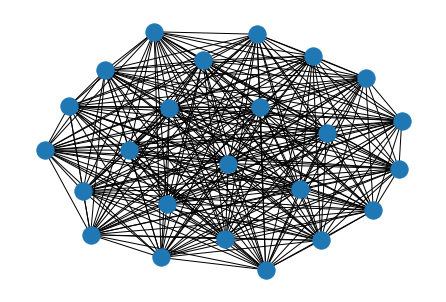

In [43]:
trial_run.create_csvs()
trial_run.plot('SiouxFalls')

# Observe example network data

In [16]:
network(cities_dict, city)

SiouxFalls graph is: DiGraph with 24 nodes and 76 edges
SiouxFalls origin nodes are: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
SiouxFalls flows are: {('1', '1'): 0.0, ('1', '2'): 100.0, ('1', '3'): 100.0, ('1', '4'): 500.0, ('1', '5'): 200.0, ('1', '6'): 300.0, ('1', '7'): 500.0, ('1', '8'): 800.0, ('1', '9'): 500.0, ('1', '10'): 1300.0, ('1', '11'): 500.0, ('1', '12'): 200.0, ('1', '13'): 500.0, ('1', '14'): 300.0, ('1', '15'): 500.0, ('1', '16'): 500.0, ('1', '17'): 400.0, ('1', '18'): 100.0, ('1', '19'): 300.0, ('1', '20'): 300.0, ('1', '21'): 100.0, ('1', '22'): 400.0, ('1', '23'): 300.0, ('1', '24'): 100.0, ('2', '1'): 100.0, ('2', '2'): 0.0, ('2', '3'): 100.0, ('2', '4'): 200.0, ('2', '5'): 100.0, ('2', '6'): 400.0, ('2', '7'): 200.0, ('2', '8'): 400.0, ('2', '9'): 200.0, ('2', '10'): 600.0, ('2', '11'): 200.0, ('2', '12'): 100.0, ('2', '13'): 300.0, ('2', '14'): 100.0, ('2', '15'): 100.

# Compute equilibrium flow using Frank-Wolfe algorithm

In [55]:
for city in cities_dict.keys():
    trial_run.compute_all_link_flow(city)

1  ->  2 :  4494.541769891608
1  ->  3 :  8118.778958018833
2  ->  1 :  4519.221797661597
2  ->  6 :  5967.415424264172
3  ->  1 :  8094.098930248844
3  ->  4 :  14011.734532365375
3  ->  12 :  10027.635980625804
6  ->  2 :  5992.095452034151
6  ->  5 :  8806.410890570694
6  ->  8 :  12492.075338963252
4  ->  3 :  14035.300255284554
4  ->  5 :  18010.561177668467
4  ->  11 :  5203.13865525387
12  ->  3 :  9979.390229936655
12  ->  11 :  8404.306735865635
12  ->  13 :  12293.499582309718
5  ->  4 :  18034.525518068713
5  ->  6 :  8797.1895868881
5  ->  9 :  15783.996289327333
11  ->  4 :  5302.740037772761
11  ->  10 :  17603.652145860353
11  ->  12 :  8365.259304287434
11  ->  14 :  9776.846543284393
9  ->  5 :  15798.73932604504
9  ->  8 :  6837.003588255241
9  ->  10 :  21745.98823492458
8  ->  6 :  12525.976670415792
8  ->  7 :  12041.696631484156
8  ->  9 :  6881.813917130209
8  ->  16 :  8387.782258682433
7  ->  8 :  12102.268632570476
7  ->  18 :  15797.411851030634
18  ->  7 :  

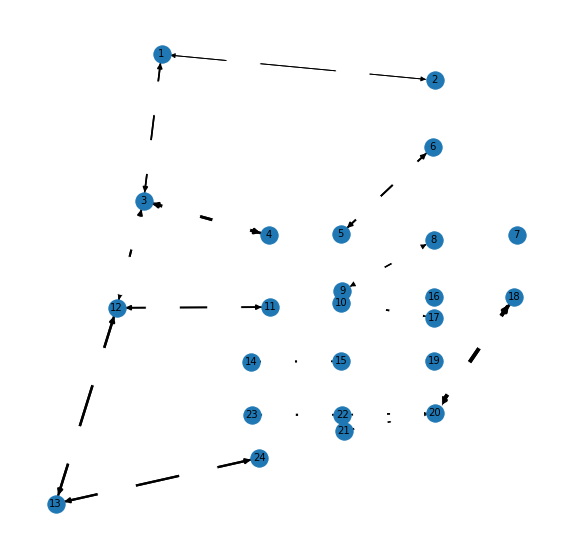

In [153]:
trial_run.cities_dict['SiouxFalls']['all_links']['all_links'].showODFlow()
trial_run.cities_dict['SiouxFalls']['all_links']['all_links'].showODFlowMap()

In [154]:
trial_run.cities_dict['SiouxFalls']['csv']

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type
0,1,2,25900.200640,6,6,0.15,4,0,0,1
1,1,3,23403.473190,4,4,0.15,4,0,0,1
2,2,1,25900.200640,6,6,0.15,4,0,0,1
3,2,6,4958.180928,5,5,0.15,4,0,0,1
4,3,1,23403.473190,4,4,0.15,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...
71,23,22,5000.000000,4,4,0.15,4,0,0,1
72,23,24,5078.508436,2,2,0.15,4,0,0,1
73,24,13,5091.256152,4,4,0.15,4,0,0,1
74,24,21,4885.357564,3,3,0.15,4,0,0,1


In [150]:
trial_run.cities_dict['SiouxFalls']['all_links']['all_links'].graph.edges

OutEdgeView([('1', '2'), ('1', '3'), ('2', '1'), ('2', '6'), ('3', '1'), ('3', '4'), ('3', '12'), ('6', '2'), ('6', '5'), ('6', '8'), ('4', '3'), ('4', '5'), ('4', '11'), ('12', '3'), ('12', '11'), ('12', '13'), ('5', '4'), ('5', '6'), ('5', '9'), ('11', '4'), ('11', '10'), ('11', '12'), ('11', '14'), ('9', '5'), ('9', '8'), ('9', '10'), ('8', '6'), ('8', '7'), ('8', '9'), ('8', '16'), ('7', '8'), ('7', '18'), ('18', '7'), ('18', '16'), ('18', '20'), ('16', '8'), ('16', '10'), ('16', '17'), ('16', '18'), ('10', '9'), ('10', '11'), ('10', '15'), ('10', '16'), ('10', '17'), ('15', '10'), ('15', '14'), ('15', '19'), ('15', '22'), ('17', '10'), ('17', '16'), ('17', '19'), ('14', '11'), ('14', '15'), ('14', '23'), ('13', '12'), ('13', '24'), ('24', '13'), ('24', '21'), ('24', '23'), ('23', '14'), ('23', '22'), ('23', '24'), ('19', '15'), ('19', '17'), ('19', '20'), ('22', '15'), ('22', '20'), ('22', '21'), ('22', '23'), ('20', '18'), ('20', '19'), ('20', '21'), ('20', '22'), ('21', '20'), (

# Systematically close each link and compute equilibrium flow

In [4]:
for city in cities_dict.keys():
    train_run.compute_missing_link_flow(city)

In [151]:
trial_run.cities_dict['SiouxFalls']['csv']

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type
0,1,2,25900.200640,6,6,0.15,4,0,0,1
1,1,3,23403.473190,4,4,0.15,4,0,0,1
2,2,1,25900.200640,6,6,0.15,4,0,0,1
3,2,6,4958.180928,5,5,0.15,4,0,0,1
4,3,1,23403.473190,4,4,0.15,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...
71,23,22,5000.000000,4,4,0.15,4,0,0,1
72,23,24,5078.508436,2,2,0.15,4,0,0,1
73,24,13,5091.256152,4,4,0.15,4,0,0,1
74,24,21,4885.357564,3,3,0.15,4,0,0,1
